<a href="https://colab.research.google.com/github/MSHDZ1/Q_late-night/blob/main/VF_Experiment_Assigment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

data = pd.read_csv('/content/rocketfuel_deciles.csv')
print(data.describe())
data.head ()

            user_id           test      converted       tot_impr  \
count  5.881010e+05  588101.000000  588101.000000  588101.000000   
mean   1.310692e+06       0.960000       0.025239      24.820876   
std    2.022260e+05       0.195959       0.156850      43.715181   
min    9.000000e+05       0.000000       0.000000       1.000000   
25%    1.143190e+06       1.000000       0.000000       4.000000   
50%    1.313725e+06       1.000000       0.000000      13.000000   
75%    1.484088e+06       1.000000       0.000000      27.000000   
max    1.654483e+06       1.000000       1.000000    2065.000000   

       mode_impr_day  mode_impr_hour  tot_impr_decile  
count  588101.000000   588101.000000    588101.000000  
mean        4.025533       14.469061         5.448068  
std         2.004019        4.834634         2.862418  
min         1.000000        0.000000         1.000000  
25%         2.000000       11.000000         3.000000  
50%         4.000000       14.000000         5.0000

,user_id,test,converted,tot_impr,mode_impr_day,mode_impr_hour,tot_impr_decile
0,1391842,1,0,2,3,19,2
1,1215269,1,0,1,4,12,1
2,1604030,1,0,2,6,11,2
3,1278452,1,0,1,7,18,1
4,1363432,1,0,1,6,13,1


Looking at summary statistics:


*   Test Variable, the mean shows a 96% that means that this percentage of user was exposed to the ad. This makes sense as the business case explained that a control group of 4% was desired.
*   Converted, shows a mean of 2.5%.
*   Tot_imp_decile, 10 equal size groups.






In [4]:
#Check for balance: In a table, compare the shares of individuals by treatment status,
#and the means and standard deviations of pre-experiment variables.
#Comment on your findings.

print(data.mean())

balance_table = data [['test', 'converted', 'tot_impr', 'mode_impr_day', 'mode_impr_hour', 'tot_impr_decile']].groupby('test').mean()
print(balance_table)

user_id            1.310692e+06
test               9.600001e-01
converted          2.523886e-02
tot_impr           2.482088e+01
mode_impr_day      4.025533e+00
mode_impr_hour     1.446906e+01
tot_impr_decile    5.448068e+00
dtype: float64
      converted   tot_impr  mode_impr_day  mode_impr_hour  tot_impr_decile
test                                                                      
0      0.017854  24.761138       3.952644       14.304923         5.325030
1      0.025547  24.823365       4.028570       14.475900         5.453194


We can see a slight higher convertion in the treatment group. We will further our analysis to revise if this is statistically significant.

From the mean in the pre-experiment variables we can determine that the treatment and control groups are well balanced., there are only minor differnces in mean.

In [8]:
#Plot outcome: Plot the means and confidence intervals of the main outcome “converted,”
##treatment status. In your markdown, file, interpret the result (mean and confidence intervals, noting width).

p_means = data.groupby('test')['converted'].agg(
    mean = ('mean'),
    std = ('std'),
    N = ('size')
)
p_means['se'] = p_means['std']/np.sqrt(p_means['N'])
p_means['lb'] = p_means['mean'] - 1.96*p_means['se']
p_means['ub'] = p_means['mean'] + 1.96*p_means['se']

print(p_means[['mean', 'lb', 'ub']])


          mean        lb        ub
test                              
0     0.017854  0.016162  0.019546
1     0.025547  0.025135  0.025958


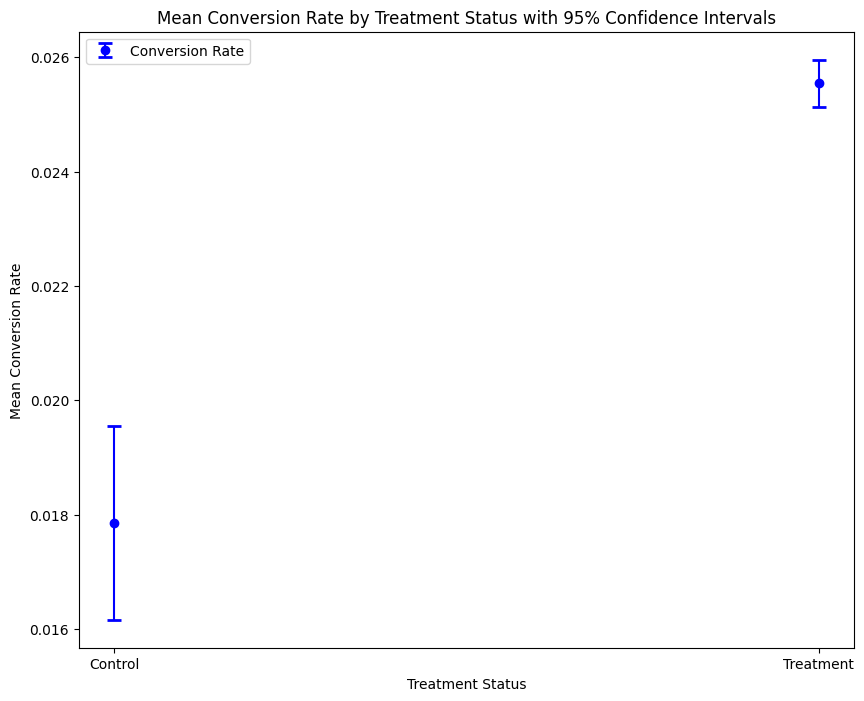

In [10]:
#Plot

plt.figure(figsize=(10, 8))
plt.errorbar(
    x=p_means.index,
    y=p_means['mean'],
    yerr=[p_means['mean'] - p_means['lb'], p_means['ub'] - p_means['mean']],
    fmt='o',
    capsize=5,
    capthick=2,
    color='blue',
    label='Conversion Rate'
)

# Add labels and title
plt.xticks([0, 1], ['Control', 'Treatment'])
plt.xlabel('Treatment Status')
plt.ylabel('Mean Conversion Rate')
plt.title('Mean Conversion Rate by Treatment Status with 95% Confidence Intervals')
plt.legend()

The control group has a mean conversion rate of 0.017854 and confidence intervals [0.016162, 0.019546]

Then treatment grup has a mean 0.025547 conversion rate and confidence intervals [0.025135  0.025958]

The conficence interval between the two groups are not overlapping, this indicates that the conversion rate between the two groups might be statistically significant and not due to randomization. The treatment group shows a higher mean that the control, also it shows narrower confidence intervals. This might be due to the fact that the sample size is quite large for the treatment group, not so for the control group.



In [19]:
#Find ATE: Estimate of the Average Treatment Effect (ATE)
#of the ads for treatment relative to control, the associated standard error,
#and the 95% confidence interval on the Average Treatment Effects.
#You can do this by hand or with regression (but be careful about standard errors).

p_ate = p_means['mean']- p_means['mean'][0]
p_ate = p_ate.to_frame(name='ate')
print(p_ate)

p_ate['se'] = np.sqrt( p_means['se']**2 + p_means['se'][0]**2 )
p_ate['lb'] = p_ate['ate'] - 1.96*p_ate['se']
p_ate['ub'] = p_ate['ate'] + 1.96*p_ate['se']

print(p_ate[['se','ate', 'lb', 'ub']])

           ate
test          
0     0.000000
1     0.007692
            se       ate        lb        ub
test                                        
0     0.001221  0.000000 -0.002393  0.002393
1     0.000889  0.007692  0.005951  0.009434


In [17]:
#use regression
formula = 'converted ~ C(test)'
model = smf.ols(formula, data= data ).fit()
model = model.get_robustcov_results(cov_type='HC3')
print(model.summary() )

                            OLS Regression Results                            
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     74.94
Date:                Sat, 26 Oct 2024   Prob (F-statistic):           4.86e-18
Time:                        21:57:18   Log-Likelihood:             2.5499e+05
No. Observations:              588101   AIC:                        -5.100e+05
Df Residuals:                  588099   BIC:                        -5.099e+05
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0179      0.001     20.678   

In [29]:
#Subgroup analysis: Create a summary table showing the treatment effect in each decile.
#Your table should indicate the decile,
##control mean, HTE, lift, and 95% CI for the HTE.

## Alternative way of making our HTE table
alt_table = data.groupby(['tot_impr_decile', 'converted'])['test'].agg(
    mean = 'mean', sem = 'sem' )

## Alt table stacks up the subgroup-specific ATE tables
print(alt_table)

# We can also unstack them, so tat each subgroup is a row
# There are separate columns for each treatment arm mean and SEM
alt_table  = alt_table.unstack()
print(alt_table)

# We can grab a particular treatment arm's variable using integer indexes:
# for example, here is the control mean
print('\n\n Control group mean in each type:')
print(alt_table['mean'][0])

                               mean       sem
tot_impr_decile converted                    
1               0          0.959216  0.000832
                1          0.966292  0.019239
2               0          0.952542  0.000813
                1          0.960000  0.014856
3               0          0.956379  0.000891
                1          0.935135  0.018157
4               0          0.957523  0.000835
                1          0.944000  0.014571
5               0          0.964355  0.000740
                1          0.965197  0.008839
6               0          0.970164  0.000709
                1          0.969095  0.008140
7               0          0.958789  0.000788
                1          0.955847  0.007101
8               0          0.961841  0.000875
                1          0.966697  0.005386
9               0          0.961724  0.000808
                1          0.974951  0.002819
10              0          0.954866  0.000936
                1          0.97523

In [34]:

# Q4 alternative, continued.
# Continuing with alternate approach
# So we can make ATE, lift, and CI, but note we do it separate for each treatment arm

alt_table['ate1']= alt_table['mean'][1] - alt_table['mean'][0]
alt_table['lift1']= alt_table['ate1'] / alt_table['mean'][0]
alt_table['se_ate1'] = np.sqrt(alt_table['sem'][1]**2 + alt_table['sem'][0]**2)
alt_table['lb1'] = alt_table['ate1'] - 1.96*alt_table['se_ate1']
alt_table['ub1'] = alt_table['ate1'] + 1.96*alt_table['se_ate1']

# print control mean, ate1, 95%, lift
alt_table['cmean'] = alt_table['mean'][0]
cols_to_show = ['cmean', 'ate1', 'lb1', 'ub1', 'lift1']
print(alt_table[cols_to_show])

                    cmean      ate1       lb1       ub1     lift1
converted                                                        
tot_impr_decile                                                  
1                0.959216  0.007076 -0.030667  0.044820  0.007377
2                0.952542  0.007458 -0.021703  0.036619  0.007830
3                0.956379 -0.021244 -0.056874  0.014385 -0.022213
4                0.957523 -0.013523 -0.042129  0.015082 -0.014123
5                0.964355  0.000843 -0.016542  0.018227  0.000874
6                0.970164 -0.001069 -0.017084  0.014946 -0.001102
7                0.958789 -0.002942 -0.016945  0.011061 -0.003068
8                0.961841  0.004856 -0.005838  0.015550  0.005049
9                0.961724  0.013227  0.007479  0.018975  0.013754
10               0.954866  0.020368  0.016543  0.024193  0.021330


In [35]:
# Rename columns for clarity
alt_table = alt_table.rename(columns={
    'cmean': 'Control Mean',
    'ate1': 'HTE',
    'lb1': 'CI_Lower',
    'ub1': 'CI_Upper',
    'lift1': 'Lift'
})

# Print the renamed table to verify
print(alt_table[['Control Mean', 'HTE', 'CI_Lower', 'CI_Upper', 'Lift']])

                Control Mean       HTE  CI_Lower  CI_Upper      Lift
converted                                                           
tot_impr_decile                                                     
1                   0.959216  0.007076 -0.030667  0.044820  0.007377
2                   0.952542  0.007458 -0.021703  0.036619  0.007830
3                   0.956379 -0.021244 -0.056874  0.014385 -0.022213
4                   0.957523 -0.013523 -0.042129  0.015082 -0.014123
5                   0.964355  0.000843 -0.016542  0.018227  0.000874
6                   0.970164 -0.001069 -0.017084  0.014946 -0.001102
7                   0.958789 -0.002942 -0.016945  0.011061 -0.003068
8                   0.961841  0.004856 -0.005838  0.015550  0.005049
9                   0.961724  0.013227  0.007479  0.018975  0.013754
10                  0.954866  0.020368  0.016543  0.024193  0.021330


In [42]:
#5. Create a graph that shows the mean and 95% CI on “converted” separately for treatment and control plotted over the 10 deciles of total impressions.

# Group by decile and treatment status to calculate mean, std deviation, and count
gt = data.groupby(['tot_impr_decile', 'test'])['converted'].agg(
    mean='mean', std='std', N='size'
)

# Calculate the Standard Error (SE) and control group mean for each decile
gt['se'] = gt['std'] / np.sqrt(gt['N'])
gt['Control Mean'] = gt.groupby('tot_impr_decile')['mean'].transform('first')  # Control mean per decile
gt['Control SE'] = gt.groupby('tot_impr_decile')['se'].transform('first')  # Control SE per decile

# Calculate HTE (treatment effect) and its SE per decile
gt['HTE'] = gt['mean'] - gt['Control Mean']
gt['HTE_SE'] = np.sqrt(gt['se']**2 + gt['Control SE']**2)

# Reset index for easier plotting
gt = gt.reset_index()



In [43]:
# Filter out control group rows to plot only treatment group data for HTEs
gt_plot = gt[gt['test'] == 1]

# Calculate error margins for HTE plot (95% CI)
err = [1.96 * gt_plot['HTE_SE'], 1.96 * gt_plot['HTE_SE']]


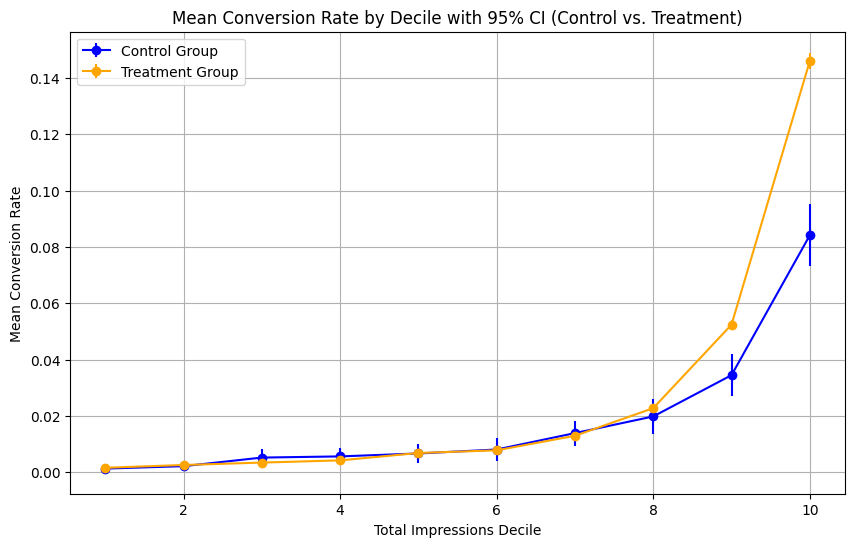

In [44]:
# Plot setup
plt.figure(figsize=(10, 6))

# Plot mean conversion rates with 95% CIs for control and treatment groups
plt.errorbar(gt[gt['test'] == 0]['tot_impr_decile'], gt[gt['test'] == 0]['mean'],
             yerr=1.96 * gt[gt['test'] == 0]['se'], fmt='o-', label='Control Group', color='blue')
plt.errorbar(gt[gt['test'] == 1]['tot_impr_decile'], gt[gt['test'] == 1]['mean'],
             yerr=1.96 * gt[gt['test'] == 1]['se'], fmt='o-', label='Treatment Group', color='orange')

# Add plot labels and legend
plt.xlabel('Total Impressions Decile')
plt.ylabel('Mean Conversion Rate')
plt.title('Mean Conversion Rate by Decile with 95% CI (Control vs. Treatment)')
plt.legend()
plt.grid(True)
plt.show()


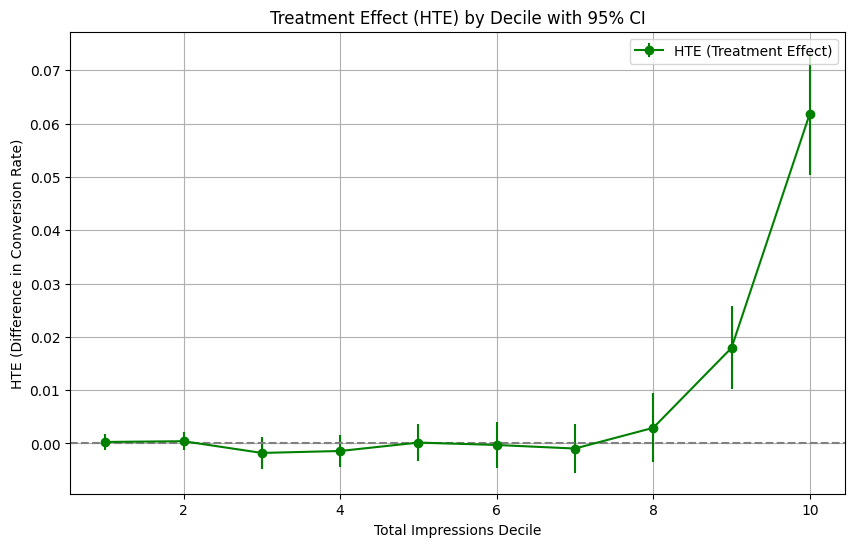

In [45]:
#5: (Bonus) Plot the HTE with 95% Confidence Intervals by Decile
# HTE plot setup
plt.figure(figsize=(10, 6))

# Plot HTE with 95% CI for each decile
plt.errorbar(gt_plot['tot_impr_decile'], gt_plot['HTE'], yerr=err, fmt='o-', color='green', label='HTE (Treatment Effect)')

# Add plot labels and reference line at zero
plt.axhline(0, color='grey', linestyle='--')  # Zero line for significance reference
plt.xlabel('Total Impressions Decile')
plt.ylabel('HTE (Difference in Conversion Rate)')
plt.title('Treatment Effect (HTE) by Decile with 95% CI')
plt.legend()
plt.grid(True)
plt.show()
